In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#sns.set() # to change theme

#from google.colab import drive
#drive.mount('/content/drive')
#display only 1 digit after decimal point
#pd.options.display.float_format = '{:.1f}'.format

In [60]:
activity = pd.read_excel('/Users/raphael/Documents/STENDO-activities/activity.xlsx')

# Travail en arrière plan

In [61]:
print('activity shape =', activity.shape)

activity shape = (522270, 15)


In [62]:
#activity

In [63]:
activity.isna().sum()

mac_address                     0
full_name                       0
name                            0
full_name.1                     0
spare_type                      0
start_date                      0
duration                        0
real_duration                   0
percentage_real_duration    30003
care_note                       0
ps_server                       0
economic_model                  0
credit_number                   0
full_name.2                     0
active                          0
dtype: int64

In [64]:
#activity[activity['percentage_real_duration'].isna()]

In [65]:
activity['percentage_real_duration'] = activity['real_duration'] / (activity['duration'] * 60) * 100

In [66]:
#activity

In [67]:
#activity.isna().sum()

In [68]:
activity = activity.drop(columns=['mac_address', 'name', 'care_note', 'credit_number', 'active'])

In [69]:
#activity

In [70]:
activity_europe = activity[(activity['ps_server'] == 'EU') & (activity['spare_type'] == 'pants')]
#activity_europe

In [71]:
activity_europe = activity_europe[activity_europe['full_name.1'] != 'T0362 - LETESTEUR Ludovic']
#activity_europe

In [72]:
activity_asia = activity[(activity['ps_server'] == 'ASIA') & (activity['spare_type'] == 'pants')]
#activity_asia

In [73]:
activity_europe_50 = activity_europe[activity_europe['percentage_real_duration'] >= 50]
#activity_europe_50

In [74]:
activity_asia_50 = activity_asia[activity_asia['percentage_real_duration'] >= 50]
#activity_asia_50

In [75]:
activity_europe_50 = activity_europe_50.sort_values(by=['full_name.1'])
#activity_europe_50

In [76]:
sorted_activity_europe_50 = activity_europe_50.groupby('full_name.1').size().reset_index(name='counts')
#sorted_activity_europe_50

In [77]:
first_activity_dates = activity_europe_50.groupby('full_name.1')['start_date'].min().reset_index()
first_activity_dates.rename(columns={'start_date': 'first_activity'}, inplace=True)
sorted_activity_europe_50 = pd.merge(sorted_activity_europe_50, first_activity_dates, on='full_name.1', how='left')
#sorted_activity_europe_50

In [78]:
last_activity_dates = activity_europe_50.groupby('full_name.1')['start_date'].max().reset_index()
last_activity_dates.rename(columns={'start_date': 'last_activity'}, inplace=True)
sorted_activity_europe_50 = pd.merge(sorted_activity_europe_50, last_activity_dates, on='full_name.1', how='left')
#sorted_activity_europe_50

In [79]:
import datetime

sorted_activity_europe_50['first_activity'] = pd.to_datetime(sorted_activity_europe_50['first_activity'])
sorted_activity_europe_50['last_activity'] = pd.to_datetime(sorted_activity_europe_50['last_activity'])
# changer le mode de calcul du nombre de jours. Ce n'est plus le nolbre de jours entre la première et la dernière activité mais le nombre de jours entre la première activité et la date du jour
# sorted_activity_europe_50['last_activity'] = pd.to_datetime(sorted_activity_europe_50['last_activity'])
sorted_activity_europe_50['number_days'] = 1 + (pd.to_datetime(datetime.date.today()) - sorted_activity_europe_50['first_activity']).dt.days
#sorted_activity_europe_50

In [80]:
# prompt: Add an extra column to sorted_activity_europe_50 called activity_last_7_days. The entries of the column activity_last_7_days should be equal to the counts of entries of full_name.1 between the current date and the curret date minus7 days

# Assuming 'start_date' column is already datetime objects. If not, convert it first:
# sorted_activity_europe_50['start_date'] = pd.to_datetime(sorted_activity_europe_50['start_date'])

import datetime

# Ensure 'start_date' in activity_europe_50 is datetime
activity_europe_50['start_date'] = pd.to_datetime(activity_europe_50['start_date'])

def count_activity_last_n_days(df, user, n_days):
    today = datetime.date.today()
    start_date = today - datetime.timedelta(days=n_days)
    user_activity = df[df['full_name.1'] == user]
    last_n_days_activity = user_activity[
        (user_activity['start_date'].dt.date >= start_date) &
        (user_activity['start_date'].dt.date <= today)
    ]
    return len(last_n_days_activity)

activity_data = []
for user in sorted_activity_europe_50['full_name.1']:
    activity_data.append({
        'full_name.1': user,
        'activity_last_7_days': count_activity_last_n_days(activity_europe_50, user, 7),
        'activity_last_14_days': count_activity_last_n_days(activity_europe_50, user, 14),
         'activity_last_30_days': count_activity_last_n_days(activity_europe_50, user, 30),
         'activity_last_90_days': count_activity_last_n_days(activity_europe_50, user, 90),
         'activity_last_365_days': count_activity_last_n_days(activity_europe_50, user, 365)
    })

activity_df = pd.DataFrame(activity_data)
#merged the two dataframes  activity_df and sorted_activity_europe_50
sorted_activity_europe_50 = pd.merge(sorted_activity_europe_50, activity_df, on='full_name.1', how='left')

In [81]:
sorted_activity_europe_50['activity_per_day_since_acquisition'] = sorted_activity_europe_50['counts'] / sorted_activity_europe_50['number_days']
sorted_activity_europe_50['activity_per_day_7_days'] = sorted_activity_europe_50['activity_last_7_days'] / 5
sorted_activity_europe_50['activity_per_day_14_days'] = sorted_activity_europe_50['activity_last_14_days'] / 10
sorted_activity_europe_50['activity_per_day_30_days'] = sorted_activity_europe_50['activity_last_30_days'] / 20
sorted_activity_europe_50['activity_per_day_90_days'] = sorted_activity_europe_50['activity_last_90_days'] / 55
sorted_activity_europe_50['activity_per_day_year'] = sorted_activity_europe_50['activity_last_365_days'] / 220
#sorted_activity_europe_50
#round the result to 1 digit after the comma
sorted_activity_europe_50 = sorted_activity_europe_50.round({'activity_per_day_since_acquisition': 2, 'activity_per_day_7_days': 2, 'activity_per_day_14_days': 2, 'activity_per_day_30_days': 2, 'activity_per_day_90_days': 2, 'activity_per_day_year': 2})

In [82]:
#sorted_activity_europe_50 = sorted_activity_europe_50.sort_values(by=['activity_per_day_since_acquisition'], ascending=False)

#Test
sorted_activity_europe_50 = sorted_activity_europe_50.sort_values(by=['activity_last_365_days'], ascending=False)
#fin test


sorted_activity_europe_50

,full_name.1,counts,first_activity,last_activity,number_days,activity_last_7_days,activity_last_14_days,activity_last_30_days,activity_last_90_days,activity_last_365_days,activity_per_day_since_acquisition,activity_per_day_7_days,activity_per_day_14_days,activity_per_day_30_days,activity_per_day_90_days,activity_per_day_year
92,T0613 - Aqua Kiné Santé,21593,2021-05-31 08:37:59,2025-01-06 14:29:11,1325,0,35,155,952,5541,16.30,0.0,3.5,7.75,17.31,25.19
8,T0100 - Franck ARCHIMBAUD,21681,2020-02-10 16:07:32,2025-01-06 14:53:22,1801,0,19,107,542,4002,12.04,0.0,1.9,5.35,9.85,18.19
12,T0108 - UAB MEDA LT,12493,2021-05-19 09:56:33,2025-01-06 14:56:06,1337,0,42,186,892,3429,9.34,0.0,4.2,9.30,16.22,15.59
116,T0711 - KINE FLOW,5805,2021-05-28 21:38:38,2025-01-06 14:32:00,1328,0,17,91,545,2676,4.37,0.0,1.7,4.55,9.91,12.16
146,T0821 - PROKINETIC,9721,2021-11-04 12:23:33,2025-01-06 14:08:15,1168,0,45,170,710,2482,8.32,0.0,4.5,8.50,12.91,11.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,T0629 - Bouhanni Nacer,3,2021-02-19 17:41:48,2021-06-04 14:14:54,1426,0,0,0,0,0,0.00,0.0,0.0,0.00,0.00,0.00
108,T0671 - A.L.M Evreux Basket,252,2021-04-15 17:34:21,2023-05-11 19:12:19,1371,0,0,0,0,0,0.18,0.0,0.0,0.00,0.00,0.00
109,T0676 - Michel RIQUOIR,57,2022-03-21 11:08:58,2022-04-28 09:31:45,1031,0,0,0,0,0,0.06,0.0,0.0,0.00,0.00,0.00
112,T0690 - SCM KINÉ GRIGNY,59,2022-01-24 17:29:31,2022-03-10 11:26:21,1087,0,0,0,0,0,0.05,0.0,0.0,0.00,0.00,0.00


In [83]:
sorted_activity_europe_50['rank_activity_7_days'] = sorted_activity_europe_50['activity_last_7_days'].rank(ascending=False, method='min').astype(int)
sorted_activity_europe_50['rank_activity_14_days'] = sorted_activity_europe_50['activity_last_14_days'].rank(ascending=False, method='min').astype(int)
sorted_activity_europe_50['rank_activity_30_days'] = sorted_activity_europe_50['activity_last_30_days'].rank(ascending=False, method='min').astype(int)
sorted_activity_europe_50['rank_activity_90_days'] = sorted_activity_europe_50['activity_last_90_days'].rank(ascending=False, method='min').astype(int)
sorted_activity_europe_50['rank_activity_year'] = sorted_activity_europe_50['activity_last_365_days'].rank(ascending=False, method='min').astype(int)
sorted_activity_europe_50['rank_activity_per_day_since_acquisition'] = sorted_activity_europe_50['activity_per_day_since_acquisition'].rank(ascending=False, method='min').astype(int)
sorted_activity_europe_50['rank_activity_per_day_7_days'] = sorted_activity_europe_50['activity_per_day_7_days'].rank(ascending=False, method='min').astype(int)
sorted_activity_europe_50['rank_activity_per_day_14_days'] = sorted_activity_europe_50['activity_per_day_14_days'].rank(ascending=False, method='min').astype(int)
sorted_activity_europe_50['rank_activity_per_day_30_days'] = sorted_activity_europe_50['activity_per_day_30_days'].rank(ascending=False, method='min').astype(int)
sorted_activity_europe_50['rank_activity_per_day_90_days'] = sorted_activity_europe_50['activity_per_day_90_days'].rank(ascending=False, method='min').astype(int)
sorted_activity_europe_50['rank_activity_per_day_year'] = sorted_activity_europe_50['activity_per_day_year'].rank(ascending=False, method='min').astype(int)

#sorted_activity_europe_50

In [84]:
sorted_activity_europe_50['percentage_total_activity_per_day'] = (sorted_activity_europe_50['activity_per_day_since_acquisition'] / sorted_activity_europe_50['activity_per_day_since_acquisition'].sum()) * 100
#sorted_activity_europe_50

In [85]:
sorted_activity_europe_50['cumulated_percentage_total_activity_per_day'] = sorted_activity_europe_50['percentage_total_activity_per_day'].cumsum()
#sorted_activity_europe_50

In [86]:


from datetime import datetime
from dateutil import relativedelta
import calendar



#add a column to sorted_activity_europe_50 called today, it should be equal to the current date
sorted_activity_europe_50['today'] = datetime.today().date()

# Function to format timedelta using relativedelta
def format_timedelta(start_date, end_date):
    delta = relativedelta.relativedelta(end_date, start_date)
    years = delta.years
    months = delta.months
    days = delta.days
    return f"{years} an(s), {months} mois, {days} jour(s)"

# Example usage with your DataFrame:
sorted_activity_europe_50['formatted_duration'] = sorted_activity_europe_50.apply(
    lambda row: format_timedelta(row['first_activity'], row['today']), axis=1
)

# Liste des clients non rentables

# Sur 7 jours

In [87]:
# @title
# Display sorted_activity_europe_50 with activity_last_7_days < 1.25, showing only 'full_name.1' and 'activity_last_7_days'
display_unprofitable_clients_activity_per_days_7_days = sorted_activity_europe_50[sorted_activity_europe_50['activity_per_day_7_days'] < 1.25][['full_name.1', 'activity_per_day_7_days']].sort_values(by=['activity_per_day_7_days'], ascending=False)
display_unprofitable_clients_activity_per_days_7_days = display_unprofitable_clients_activity_per_days_7_days.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_per_day_7_days': 'Nombre moyen séance par jours sur les 7 derniers jours',
        })
print(f"{len(display_unprofitable_clients_activity_per_days_7_days)} clients sur "+ f"{len(sorted_activity_europe_50)}" + " ne sont pas rentables sur les 7 derniers jours")
display(display_unprofitable_clients_activity_per_days_7_days.style.format({"Nombre moyen séance par jours sur les 7 derniers jours": "{:.2f}"}).hide(axis='index'))

361 clients sur 361 ne sont pas rentables sur les 7 derniers jours


Nom du client,Nombre moyen séance par jours sur les 7 derniers jours
T0613 - Aqua Kiné Santé,0.00
T0631 - KANZLSPERGER GmbH,0.00
T0762 - VOLANT SERVICES MANAGEMENT,0.00
T1769 - LEDEN LASER,0.00
T1817 - Laure GUIRAL,0.00
T1620 - PENSULA SL,0.00
T0806 - HOITOLA WOMAN,0.00
T1764 - Marion JENNY-SAUVEBOIS,0.00
T1390 - Zell Spa AG,0.00
T0142 - Myriam LAVOINE (Kiné 62),0.00


# Sur  14 jours

In [88]:
# @title
display_unprofitable_clients_activity_per_days_14_days = sorted_activity_europe_50[sorted_activity_europe_50['activity_per_day_14_days'] < 1.25][['full_name.1', 'activity_per_day_14_days']].sort_values(by=['activity_per_day_14_days'], ascending=False)
display_unprofitable_clients_activity_per_days_14_days = display_unprofitable_clients_activity_per_days_14_days.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_per_day_14_days': 'Nombre moyen séance par jours sur les 14 derniers jours',
        })
print(f"{len(display_unprofitable_clients_activity_per_days_14_days)} clients sur "+ f"{len(sorted_activity_europe_50)}" + " ne sont pas rentables sur les 14 derniers jours")
display(display_unprofitable_clients_activity_per_days_14_days.style.format({"Nombre moyen séance par jours sur les 14 derniers jours": "{:.2f}"}).hide(axis='index'))

341 clients sur 361 ne sont pas rentables sur les 14 derniers jours


Nom du client,Nombre moyen séance par jours sur les 14 derniers jours
T1274 - STENDO BEAUTY AU,1.20
T0941 - Lionel BOUDON,1.20
T0820 - Nicolas BOCACCIO,1.20
T1360 - Guillaume BRUNEL - Pauline GAGNIERE,1.10
T0646 - Stéphanie BERTHON,1.10
T0139 - KIWI SANTE,1.10
T1754 - Christelle DUQUESNE,1.10
T0937 - SCM KINEMOTIV,1.00
T0999 - Jérôme DUCHATELET,1.00
T1408 - Mandy ROURRET,0.90


# Sur 30 jours

In [89]:
# @title
display_unprofitable_clients_activity_per_days_30_days = sorted_activity_europe_50[(sorted_activity_europe_50['activity_per_day_30_days'] < 1.25) & (sorted_activity_europe_50['number_days'] > 30)][['full_name.1', 'activity_per_day_30_days']].sort_values(by=['activity_per_day_30_days'], ascending=False)
display_unprofitable_clients_activity_per_days_30_days = display_unprofitable_clients_activity_per_days_30_days.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_per_day_30_days': 'Nombre moyen séance par jours sur les 30 derniers jours',
        })
print(f"{len(display_unprofitable_clients_activity_per_days_30_days)} clients sur "+ f"{len(sorted_activity_europe_50[sorted_activity_europe_50['number_days']>30])}" + " ne sont pas rentables sur les 30 derniers jours")
display(display_unprofitable_clients_activity_per_days_30_days.style.format({"Nombre moyen séance par jours sur les 30 derniers jours": "{:.2f}"}).hide(axis='index'))

273 clients sur 356 ne sont pas rentables sur les 30 derniers jours


Nom du client,Nombre moyen séance par jours sur les 30 derniers jours
T1749 - Elise PEREZ,1.20
T1779 - Anne Sophie MABILLE,1.20
T1613 - Gloria GARCIA,1.20
T0368 - RADENNE Denis,1.20
T1758 - SCM ReeduKA Moulin,1.15
T1595 - Anne-Sophie MARCHAND,1.10
T1329 - Brahem MESSAOUI,1.10
T1014 - SCM FLAUGERGUES,1.10
T0525 - FISIOLAB 8.14 S.R.L.,1.10
T0839 - L'ASTRAGALE SELAS,1.10


# Sur 90 jours

In [90]:
# @title
display_unprofitable_clients_activity_per_days_90_days = sorted_activity_europe_50[(sorted_activity_europe_50['activity_per_day_90_days'] < 1.25) & (sorted_activity_europe_50['number_days'] > 90)][['full_name.1', 'activity_per_day_90_days']].sort_values(by=['activity_per_day_90_days'], ascending=False)
display_unprofitable_clients_activity_per_days_90_days = display_unprofitable_clients_activity_per_days_90_days.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_per_day_90_days': 'Nombre moyen séance par jours sur les 90 derniers jours',
        })
print(f"{len(display_unprofitable_clients_activity_per_days_90_days)} clients sur "+ f"{len(sorted_activity_europe_50[sorted_activity_europe_50['number_days']>90])}" + " ne sont pas rentables sur les 90 derniers jours")
display(display_unprofitable_clients_activity_per_days_90_days.style.format({"Nombre moyen séance par jours sur les 90 derniers jours": "{:.2f}"}).hide(axis='index'))

201 clients sur 340 ne sont pas rentables sur les 90 derniers jours


Nom du client,Nombre moyen séance par jours sur les 90 derniers jours
T1713 - Franck DUBOIS,1.24
T0970 - Julien JOURDAIN,1.24
T0903 - Dr Mathilde GUILLOT,1.24
T0094 - Sébastien PELLÉ,1.22
T1336 - Julien PION et Anaïs PARIS,1.11
T1708 - Edith CARTIER,1.09
T1714 - Francois BRUGIDOU,1.09
T1657 - Christophe HELIN,1.07
T0701 - Romain BOTTOIS,1.07
T0781 - SPRL MERCURE,1.07


# Sur 1 an

In [91]:
# @title
display_unprofitable_clients_activity_per_days_year = sorted_activity_europe_50[(sorted_activity_europe_50['activity_per_day_year'] < 1.25) & (sorted_activity_europe_50['number_days'] > 365)][['full_name.1', 'activity_per_day_year']].sort_values(by=['activity_per_day_year'], ascending=False)
display_unprofitable_clients_activity_per_days_year = display_unprofitable_clients_activity_per_days_year.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_per_day_year': 'Nombre moyen séance par jours sur 1 an',
        })
print(f"{len(display_unprofitable_clients_activity_per_days_year)} clients sur "+ f"{len(sorted_activity_europe_50[sorted_activity_europe_50['number_days']>365])}" + " ne sont pas rentables sur 1 an")
display(display_unprofitable_clients_activity_per_days_year.style.format({"Nombre moyen séance par jours sur 1 an": "{:.2f}"}).hide(axis='index'))

151 clients sur 275 ne sont pas rentables sur 1 an


Nom du client,Nombre moyen séance par jours sur 1 an
T0597 - SELAS CCECB,1.22
T0976 - CRYO MAUGUIO (CRYOPOLE),1.15
T1476 - Loïc LAFON,1.14
T0404 - ODENTHAL Dominique,1.14
T0788 - Jéromine PASO,1.09
T0819 - Bérengère BAS,1.07
T1450 - Centre Médical Pasteur,1.04
T1280 - MAGUS APOTHICAIRE DE BEAUTE,1.02
T1208 - Priscilla BERTHOME,0.98
T1563 - BeautySpace,0.92


# Depuis la première utilisation

In [92]:
# @title
display_unprofitable_clients_activity_per_days_year = sorted_activity_europe_50[sorted_activity_europe_50['activity_per_day_since_acquisition'] < 0.87][['full_name.1', 'activity_per_day_since_acquisition']].sort_values(by=['activity_per_day_since_acquisition'], ascending=False)
display_unprofitable_clients_activity_per_days_year = display_unprofitable_clients_activity_per_days_year.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_per_day_since_acquisition': 'Nombre moyen séance par jours sur 1 an',
        })
print(f"{len(display_unprofitable_clients_activity_per_days_year)} clients sur "+ f"{len(sorted_activity_europe_50)}" + " ne sont pas rentables")
display(display_unprofitable_clients_activity_per_days_year.style.format({"Nombre moyen séance par jours depuis la première séance": "{:.2f}"}).hide(axis='index'))

198 clients sur 361 ne sont pas rentables


Nom du client,Nombre moyen séance par jours sur 1 an
T1329 - Brahem MESSAOUI,0.860000
T0903 - Dr Mathilde GUILLOT,0.860000
T0103 - Guillaume ZELLER,0.860000
T0393 - CRYOSUD SARL,0.860000
T0396 - SEBBAGH Aurélien,0.830000
T0842 - BLC SYSTEM,0.830000
T1704 - Ozon 2000 (SRL),0.810000
T0819 - Bérengère BAS,0.810000
T1708 - Edith CARTIER,0.780000
T1311 - Audrey DELEFORTRIE,0.780000


# Classement des 30 premiers clients européens en fonction du nombre moyen de séances par jour


# Depuis l'acquisition de l'appareil V4

In [93]:
# @title
display_30_best_clients_activity_per_days_entire_period = sorted_activity_europe_50[['full_name.1', 'activity_per_day_since_acquisition', 'rank_activity_per_day_since_acquisition']]
display_30_best_clients_activity_per_days_entire_period = display_30_best_clients_activity_per_days_entire_period.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_per_day_since_acquisition': 'Nombre moyen séance par jours depuis acquisition',
    'rank_activity_per_day_since_acquisition' : 'Classement en fonction de l\'activité depuis l\'acquisition'
    })

#display_30_best_clients_activity_per_days_entire_period
#display(display_30_best_clients_activity_per_days_entire_period.head(30).style.hide(axis='index'))
display(display_30_best_clients_activity_per_days_entire_period.head(30).style.format({"Nombre moyen séance par jours depuis acquisition": "{:.1f}"}).hide(axis='index'))

Nom du client,Nombre moyen séance par jours depuis acquisition,Classement en fonction de l'activité depuis l'acquisition
T0613 - Aqua Kiné Santé,16.3,1
T0100 - Franck ARCHIMBAUD,12.0,2
T0108 - UAB MEDA LT,9.3,3
T0711 - KINE FLOW,4.4,13
T0821 - PROKINETIC,8.3,4
T0745 - Thibaut LEONE,4.7,10
T0091 - Selarl MEDVASC 32,7.1,6
T0689 - SCM KINE FORM',5.9,7
T1013 - Natalia BARTOSEK,3.2,36
T1543 - SCM KINESIO,4.9,8


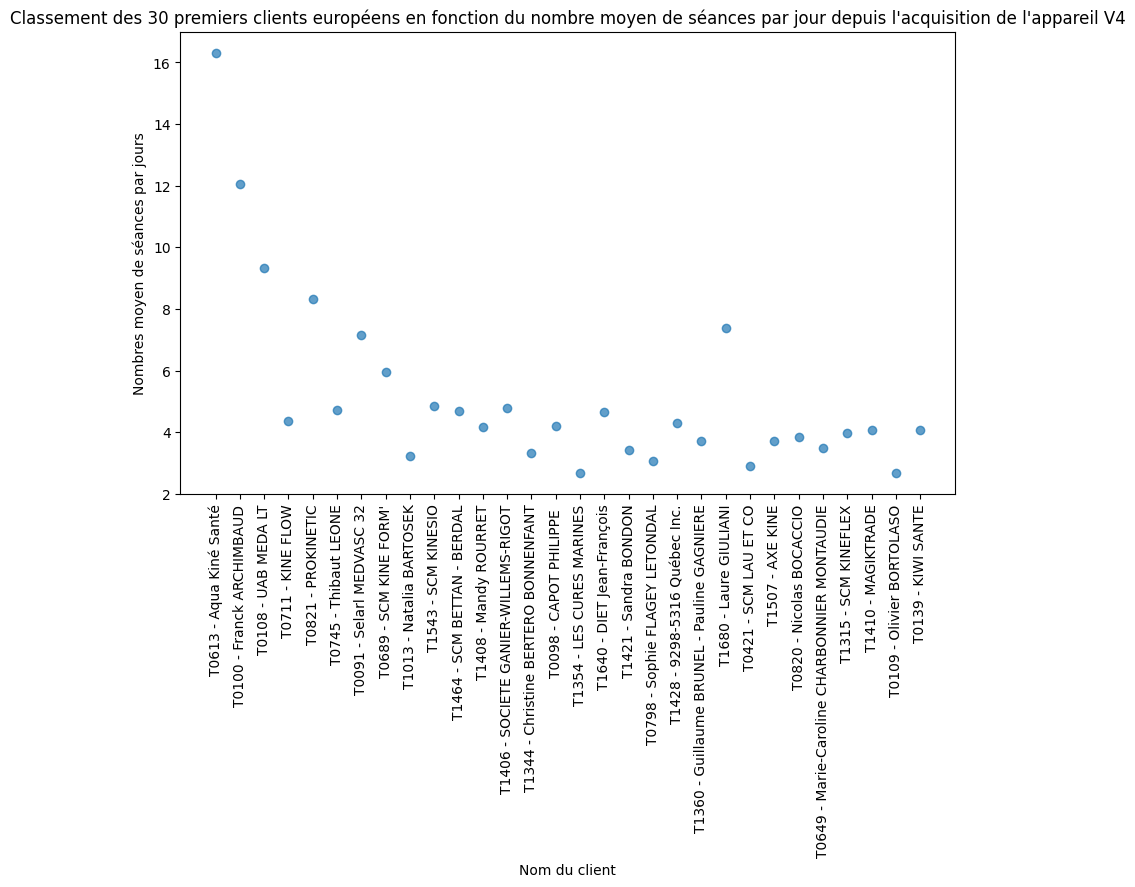

In [94]:
# @title
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(display_30_best_clients_activity_per_days_entire_period.head(30)['Nom du client'], display_30_best_clients_activity_per_days_entire_period.head(30)['Nombre moyen séance par jours depuis acquisition'],  alpha=0.7)
plt.xlabel('Nom du client')
plt.ylabel('Nombres moyen de séances par jours')
plt.title('Classement des 30 premiers clients européens en fonction du nombre moyen de séances par jour depuis l\'acquisition de l\'appareil V4')
_ = plt.xticks(rotation=90)

# sur les 7 derniers jours

In [95]:
# @title
#display_30_best_clients_activity_per_days_7_days = sorted_activity_europe_50[['full_name.1', 'activity_per_day_7_days', 'rank_activity_per_day_7_days']].sort_values(by=['activity_per_day_7_days'], ascending=False)
display_30_best_clients_activity_per_days_7_days = sorted_activity_europe_50[sorted_activity_europe_50['number_days'] > 7][['full_name.1', 'activity_per_day_7_days', 'rank_activity_per_day_7_days']].sort_values(by=['activity_per_day_7_days'], ascending=False)
display_30_best_clients_activity_per_days_7_days = display_30_best_clients_activity_per_days_7_days.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_per_day_7_days': 'Nombre moyen séances par jours sur les 7 derniers jours',
    'rank_activity_per_day_7_days' : 'Classement en fonction de l\'activité sur les 7 derniers jours'
    })


#display(display_30_best_clients_activity_per_days_7_days.head(30).style.hide(axis='index'))
display(display_30_best_clients_activity_per_days_7_days.head(30).style.format({"Nombre moyen séances par jours sur les 7 derniers jours": "{:.1f}"}).hide(axis='index'))

Nom du client,Nombre moyen séances par jours sur les 7 derniers jours,Classement en fonction de l'activité sur les 7 derniers jours
T0613 - Aqua Kiné Santé,0.0,1
T0631 - KANZLSPERGER GmbH,0.0,1
T0762 - VOLANT SERVICES MANAGEMENT,0.0,1
T1769 - LEDEN LASER,0.0,1
T1817 - Laure GUIRAL,0.0,1
T1620 - PENSULA SL,0.0,1
T0806 - HOITOLA WOMAN,0.0,1
T1764 - Marion JENNY-SAUVEBOIS,0.0,1
T1390 - Zell Spa AG,0.0,1
T0142 - Myriam LAVOINE (Kiné 62),0.0,1


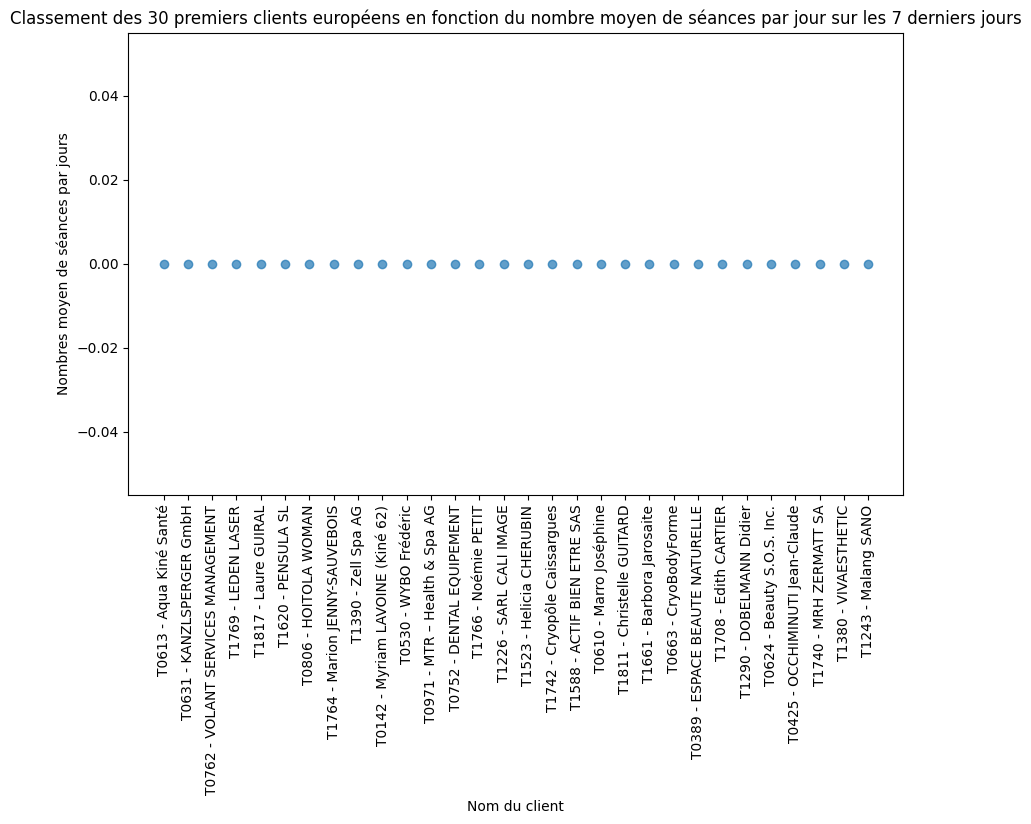

In [96]:
# @title
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(display_30_best_clients_activity_per_days_7_days.head(30)['Nom du client'], display_30_best_clients_activity_per_days_7_days.head(30)['Nombre moyen séances par jours sur les 7 derniers jours'],  alpha=0.7)
plt.xlabel('Nom du client')
plt.ylabel('Nombres moyen de séances par jours')
plt.title('Classement des 30 premiers clients européens en fonction du nombre moyen de séances par jour sur les 7 derniers jours')
_ = plt.xticks(rotation=90)

# sur les 14 derniers jours

In [97]:
# @title
#display_30_best_clients_activity_per_days_14_days = sorted_activity_europe_50[['full_name.1', 'activity_per_day_14_days', 'rank_activity_per_day_14_days']].sort_values(by=['activity_per_day_14_days'], ascending=False)
display_30_best_clients_activity_per_days_14_days = sorted_activity_europe_50[sorted_activity_europe_50['number_days'] > 14][['full_name.1', 'activity_per_day_14_days', 'rank_activity_per_day_14_days']].sort_values(by=['activity_per_day_14_days'], ascending=False)
display_30_best_clients_activity_per_days_14_days = display_30_best_clients_activity_per_days_14_days.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_per_day_14_days': 'Nombre moyen séances par jours sur les 14 derniers jours',
    'rank_activity_per_day_14_days' : 'Classement en fonction de l\'activité sur les 14 derniers jours'
    })


#display(display_30_best_clients_activity_per_days_14_days.head(30).style.hide(axis='index'))
display(display_30_best_clients_activity_per_days_14_days.head(30).style.format({"Nombre moyen séances par jours sur les 14 derniers jours": "{:.1f}"}).hide(axis='index'))

Nom du client,Nombre moyen séances par jours sur les 14 derniers jours,Classement en fonction de l'activité sur les 14 derniers jours
T0821 - PROKINETIC,4.5,1
T0108 - UAB MEDA LT,4.2,2
T0613 - Aqua Kiné Santé,3.5,3
T0689 - SCM KINE FORM',2.5,4
T1354 - LES CURES MARINES,2.4,5
T1680 - Laure GIULIANI,2.4,5
T1344 - Christine BERTERO BONNENFANT,2.3,7
T1543 - SCM KINESIO,2.2,8
T1590 - Virginie L'HERMENIER,1.9,9
T0100 - Franck ARCHIMBAUD,1.9,9


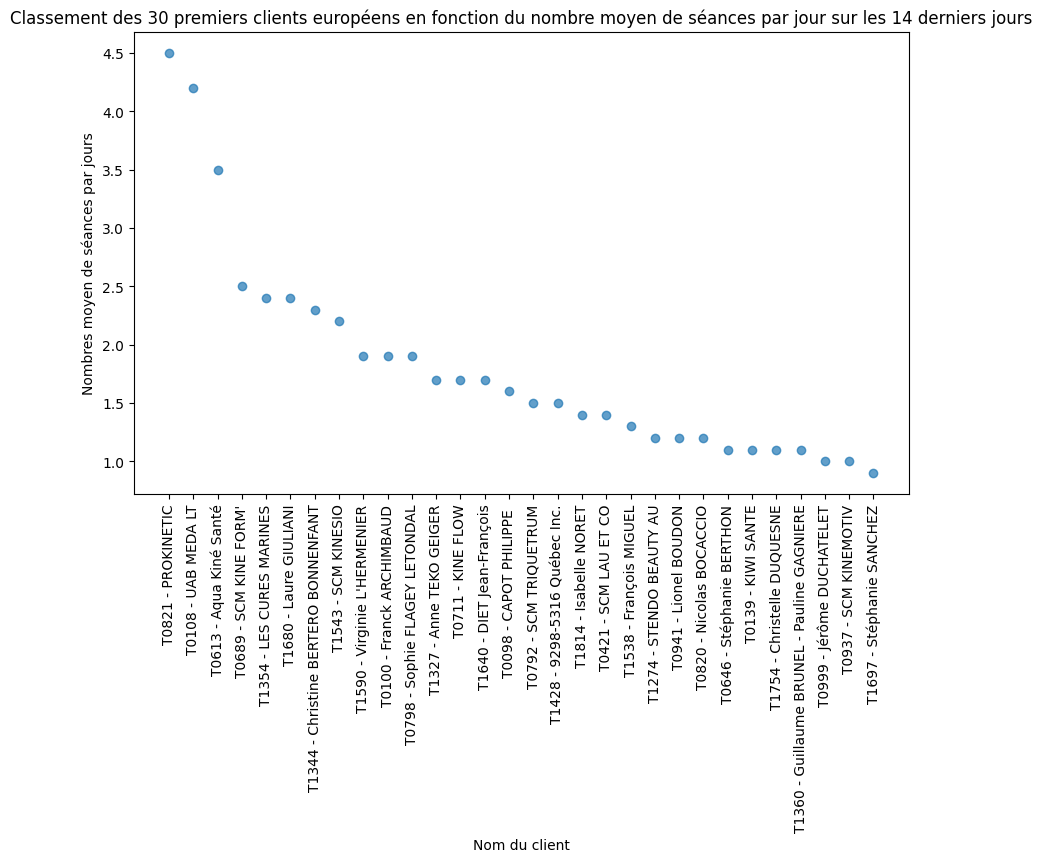

In [98]:
# @title
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(display_30_best_clients_activity_per_days_14_days.head(30)['Nom du client'], display_30_best_clients_activity_per_days_14_days.head(30)['Nombre moyen séances par jours sur les 14 derniers jours'],  alpha=0.7)
plt.xlabel('Nom du client')
plt.ylabel('Nombres moyen de séances par jours')
plt.title('Classement des 30 premiers clients européens en fonction du nombre moyen de séances par jour sur les 14 derniers jours')
_ = plt.xticks(rotation=90)

# sur les 30 derniers jours

In [99]:
# @title
#display_30_best_clients_activity_per_days_30_days = sorted_activity_europe_50[['full_name.1', 'activity_per_day_30_days', 'rank_activity_per_day_30_days']].sort_values(by=['activity_per_day_30_days'], ascending=False)
display_30_best_clients_activity_per_days_30_days = sorted_activity_europe_50[sorted_activity_europe_50['number_days'] > 30][['full_name.1', 'activity_per_day_30_days', 'rank_activity_per_day_30_days']].sort_values(by=['activity_per_day_30_days'], ascending=False)
display_30_best_clients_activity_per_days_30_days = display_30_best_clients_activity_per_days_30_days.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_per_day_30_days': 'Nombre moyen séances par jours sur les 30 derniers jours',
    'rank_activity_per_day_30_days' : 'Classement en fonction de l\'activité sur les 30 derniers jours'
    })


#display(display_30_best_clients_activity_per_days_30_days.head(30).style.hide(axis='index'))
display(display_30_best_clients_activity_per_days_30_days.head(30).style.format({"Nombre moyen séances par jours sur les 30 derniers jours": "{:.1f}"}).hide(axis='index'))

Nom du client,Nombre moyen séances par jours sur les 30 derniers jours,Classement en fonction de l'activité sur les 30 derniers jours
T0108 - UAB MEDA LT,9.3,1
T0821 - PROKINETIC,8.5,2
T1680 - Laure GIULIANI,8.0,3
T0613 - Aqua Kiné Santé,7.8,4
T0100 - Franck ARCHIMBAUD,5.3,5
T0711 - KINE FLOW,4.5,6
T1344 - Christine BERTERO BONNENFANT,4.3,7
T1640 - DIET Jean-François,4.1,8
T0689 - SCM KINE FORM',4.1,8
T0792 - SCM TRIQUETRUM,4.0,10


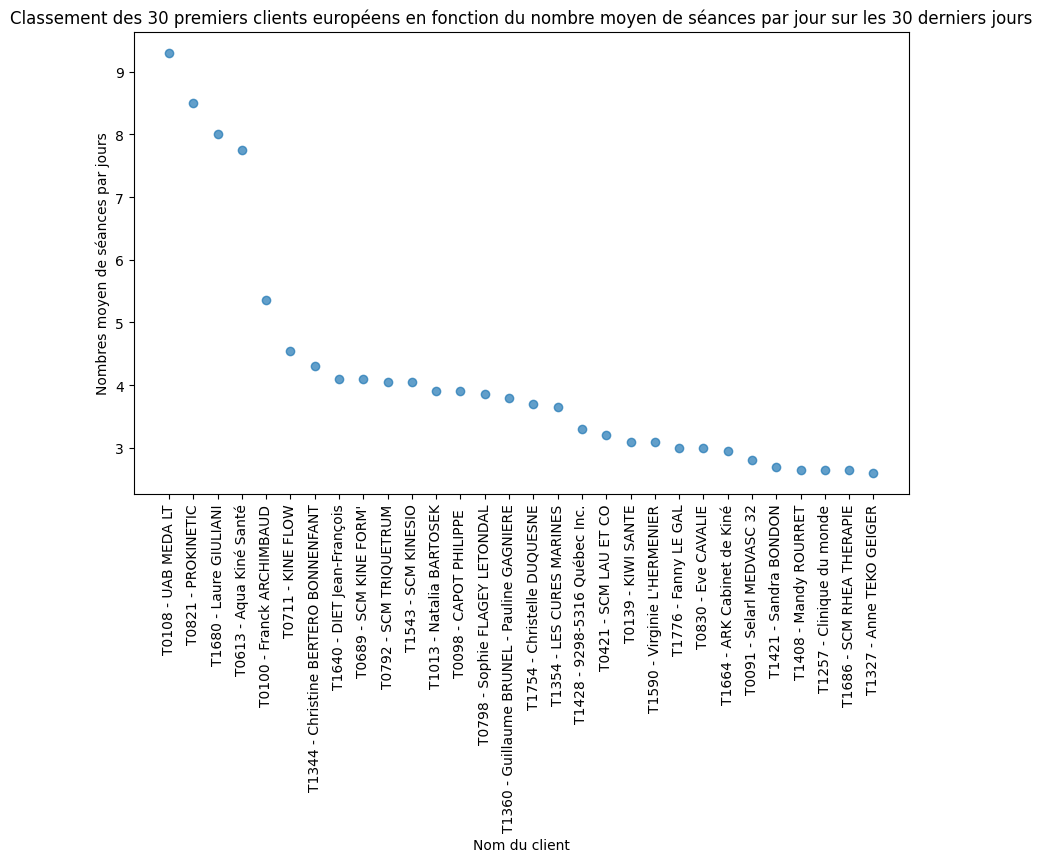

In [100]:
# @title
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(display_30_best_clients_activity_per_days_30_days.head(30)['Nom du client'], display_30_best_clients_activity_per_days_30_days.head(30)['Nombre moyen séances par jours sur les 30 derniers jours'],  alpha=0.7)
plt.xlabel('Nom du client')
plt.ylabel('Nombres moyen de séances par jours')
plt.title('Classement des 30 premiers clients européens en fonction du nombre moyen de séances par jour sur les 30 derniers jours')
_ = plt.xticks(rotation=90)

# sur les 90 derniers jours

In [101]:
# @title
#display_30_best_clients_activity_per_days_90_days = sorted_activity_europe_50[['full_name.1', 'activity_per_day_90_days', 'rank_activity_per_day_90_days']].sort_values(by=['activity_per_day_90_days'], ascending=False)
display_30_best_clients_activity_per_days_90_days = sorted_activity_europe_50[sorted_activity_europe_50['number_days'] > 90][['full_name.1', 'activity_per_day_90_days', 'rank_activity_per_day_90_days']].sort_values(by=['activity_per_day_90_days'], ascending=False)
display_30_best_clients_activity_per_days_90_days = display_30_best_clients_activity_per_days_90_days.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_per_day_90_days': 'Nombre moyen séances par jours sur les 90 derniers jours',
    'rank_activity_per_day_90_days' : 'Classement en fonction de l\'activité sur les 90 derniers jours'
    })


#display(display_30_best_clients_activity_per_days_90_days.head(30).style.hide(axis='index'))
display(display_30_best_clients_activity_per_days_90_days.head(30).style.format({"Nombre moyen séances par jours sur les 90 derniers jours": "{:.1f}"}).hide(axis='index'))

Nom du client,Nombre moyen séances par jours sur les 90 derniers jours,Classement en fonction de l'activité sur les 90 derniers jours
T0613 - Aqua Kiné Santé,17.3,1
T0108 - UAB MEDA LT,16.2,2
T0821 - PROKINETIC,12.9,3
T1680 - Laure GIULIANI,11.4,4
T0792 - SCM TRIQUETRUM,10.1,5
T0711 - KINE FLOW,9.9,6
T0100 - Franck ARCHIMBAUD,9.8,7
T0689 - SCM KINE FORM',8.9,8
T1344 - Christine BERTERO BONNENFANT,8.8,9
T0745 - Thibaut LEONE,8.3,10


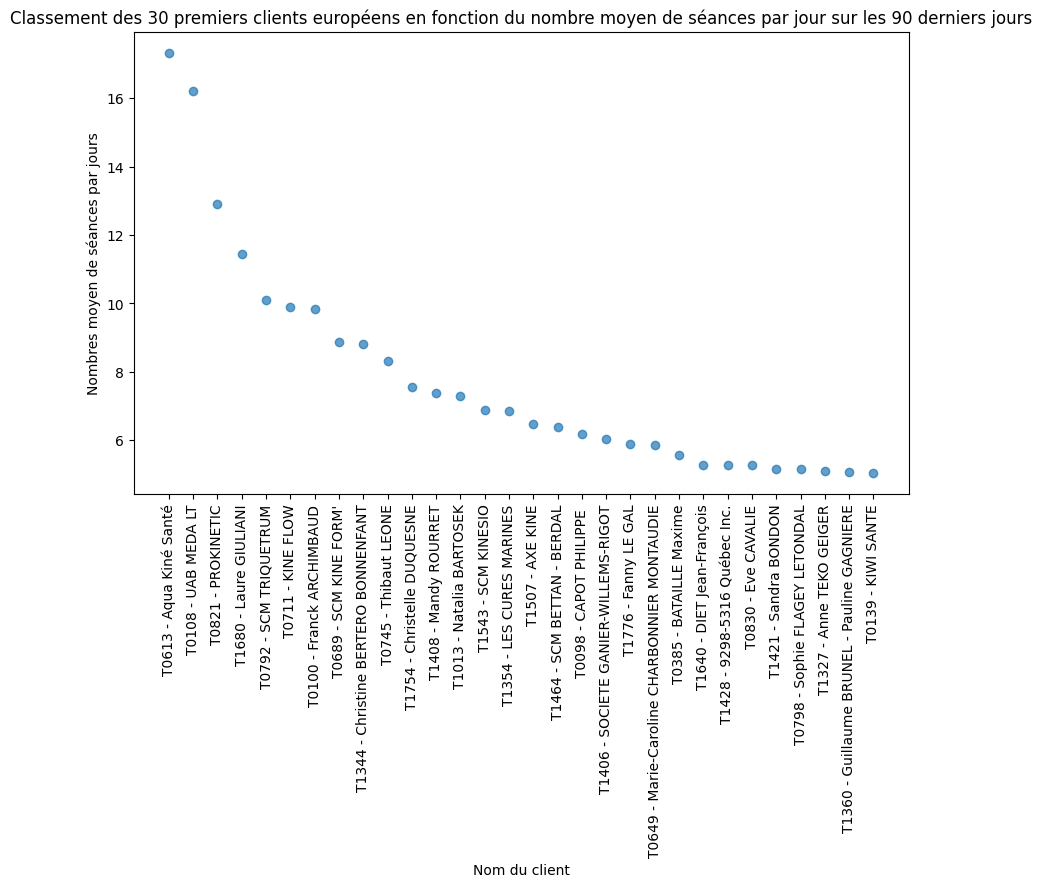

In [102]:
# @title
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(display_30_best_clients_activity_per_days_90_days.head(30)['Nom du client'], display_30_best_clients_activity_per_days_90_days.head(30)['Nombre moyen séances par jours sur les 90 derniers jours'],  alpha=0.7)
plt.xlabel('Nom du client')
plt.ylabel('Nombres moyen de séances par jours')
plt.title('Classement des 30 premiers clients européens en fonction du nombre moyen de séances par jour sur les 90 derniers jours')
_ = plt.xticks(rotation=90)

# sur 1 an

In [103]:
# @title
display_30_best_clients_activity_per_days_year = sorted_activity_europe_50[sorted_activity_europe_50['number_days'] > 365][['full_name.1', 'activity_per_day_year', 'rank_activity_per_day_year']].sort_values(by=['activity_per_day_year'], ascending=False)
display_30_best_clients_activity_per_days_year = display_30_best_clients_activity_per_days_year.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_per_day_year': 'Nombre moyen séances par jours sur 1 an',
    'rank_activity_per_day_year' : 'Classement en fonction de l\'activité sur 1 an'
    })


#display(display_30_best_clients_activity_per_days_year.head(30).style.hide(axis='index'))
display(display_30_best_clients_activity_per_days_year.head(30).style.format({"Nombre moyen séances par jours sur 1 an": "{:.1f}"}).hide(axis='index'))

Nom du client,Nombre moyen séances par jours sur 1 an,Classement en fonction de l'activité sur 1 an
T0613 - Aqua Kiné Santé,25.2,1
T0100 - Franck ARCHIMBAUD,18.2,2
T0108 - UAB MEDA LT,15.6,3
T0711 - KINE FLOW,12.2,4
T0821 - PROKINETIC,11.3,5
T0745 - Thibaut LEONE,10.4,6
T0091 - Selarl MEDVASC 32,9.9,7
T0689 - SCM KINE FORM',9.5,8
T1013 - Natalia BARTOSEK,8.2,9
T1543 - SCM KINESIO,8.1,10


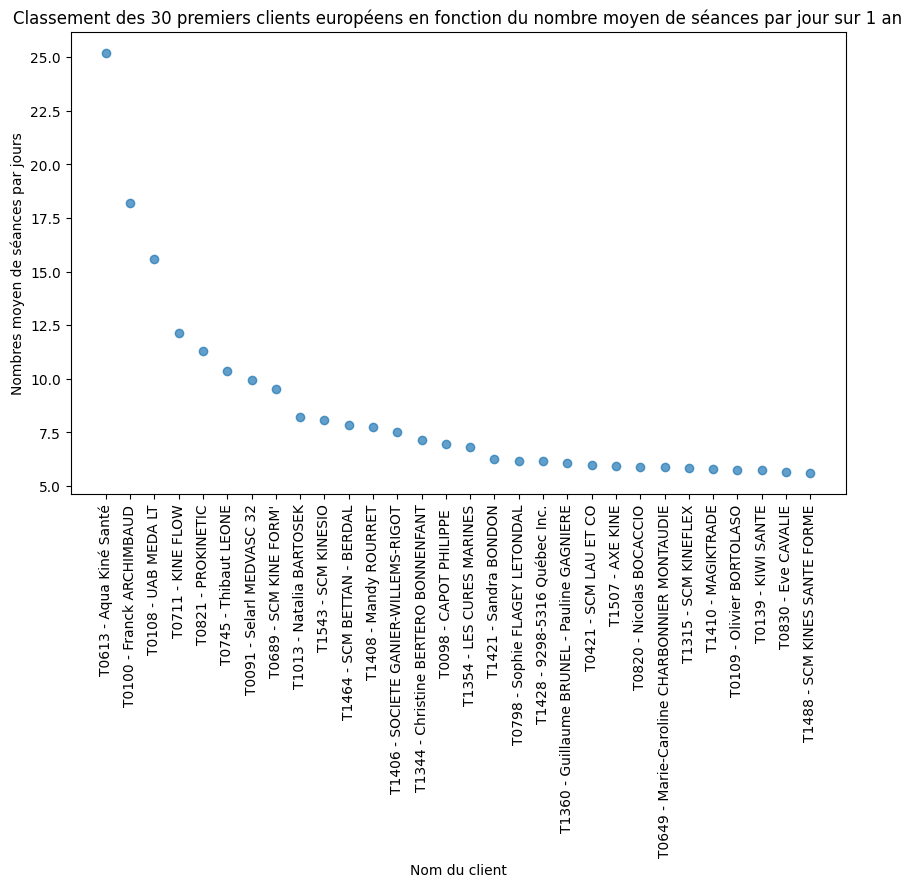

In [104]:
# @title
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(display_30_best_clients_activity_per_days_year.head(30)['Nom du client'], display_30_best_clients_activity_per_days_year.head(30)['Nombre moyen séances par jours sur 1 an'],  alpha=0.7)
plt.xlabel('Nom du client')
plt.ylabel('Nombres moyen de séances par jours')
plt.title('Classement des 30 premiers clients européens en fonction du nombre moyen de séances par jour sur 1 an')
_ = plt.xticks(rotation=90)

# Classement des 30 premiers clients européens en fonction du nombre de séances

# sur 7 jours

In [105]:
# @title
display_30_best_clients_activity_7_days = sorted_activity_europe_50[sorted_activity_europe_50['number_days'] > 7][['full_name.1', 'activity_last_7_days', 'rank_activity_7_days']].sort_values(by=['activity_last_7_days'], ascending=False)
display_30_best_clients_activity_7_days = display_30_best_clients_activity_7_days.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_last_7_days': 'Nombre de séances sur les 7 derniers jours',
    'rank_activity_7_days' : 'Classement en fonction de l\'activité sur les 7 derniers jours'
    })


display(display_30_best_clients_activity_7_days.head(30).style.hide(axis='index'))

Nom du client,Nombre de séances sur les 7 derniers jours,Classement en fonction de l'activité sur les 7 derniers jours
T0613 - Aqua Kiné Santé,0,1
T0631 - KANZLSPERGER GmbH,0,1
T0762 - VOLANT SERVICES MANAGEMENT,0,1
T1769 - LEDEN LASER,0,1
T1817 - Laure GUIRAL,0,1
T1620 - PENSULA SL,0,1
T0806 - HOITOLA WOMAN,0,1
T1764 - Marion JENNY-SAUVEBOIS,0,1
T1390 - Zell Spa AG,0,1
T0142 - Myriam LAVOINE (Kiné 62),0,1


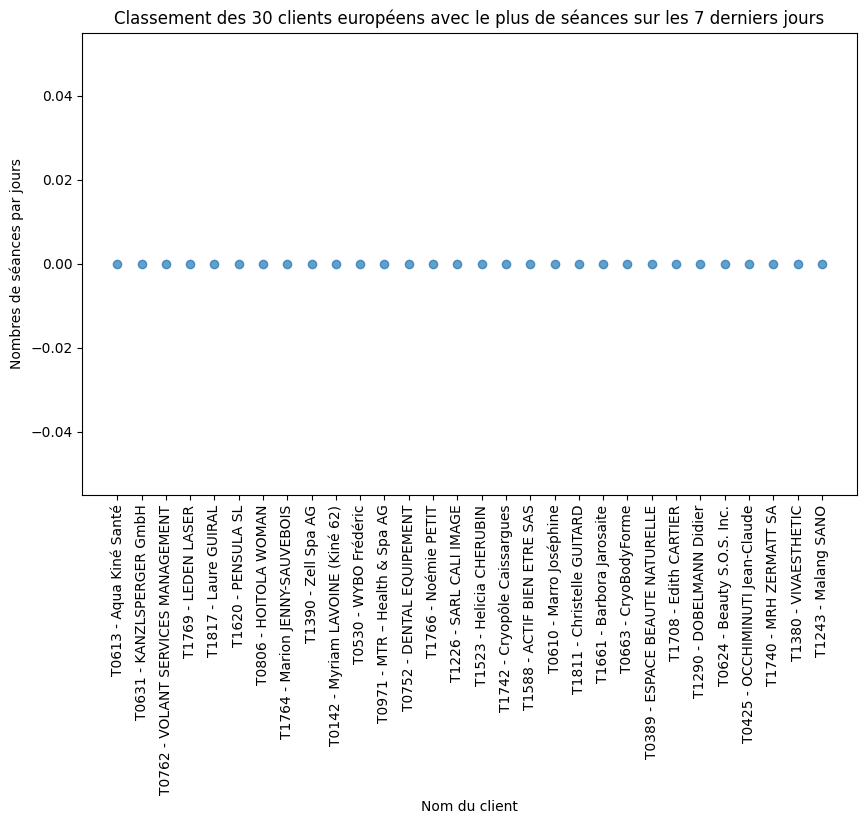

In [106]:
# @title
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(display_30_best_clients_activity_7_days.head(30)['Nom du client'], display_30_best_clients_activity_7_days.head(30)['Nombre de séances sur les 7 derniers jours'], alpha=0.7)
plt.xlabel('Nom du client')
plt.ylabel('Nombres de séances par jours')
plt.title('Classement des 30 clients européens avec le plus de séances sur les 7 derniers jours')
_ = plt.xticks(rotation=90)

# sur 14 jours

In [107]:
# @title
display_30_best_clients_activity_14_days = sorted_activity_europe_50[sorted_activity_europe_50['number_days'] > 14][['full_name.1', 'activity_last_14_days', 'rank_activity_14_days']].sort_values(by=['activity_last_14_days'], ascending=False)
display_30_best_clients_activity_14_days = display_30_best_clients_activity_14_days.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_last_14_days': 'Nombre de séances sur les 14 derniers jours',
    'rank_activity_14_days' : 'Classement en fonction de l\'activité sur les 14 derniers jours'
    })


display(display_30_best_clients_activity_14_days.head(30).style.hide(axis='index'))

Nom du client,Nombre de séances sur les 14 derniers jours,Classement en fonction de l'activité sur les 14 derniers jours
T0821 - PROKINETIC,45,1
T0108 - UAB MEDA LT,42,2
T0613 - Aqua Kiné Santé,35,3
T0689 - SCM KINE FORM',25,4
T1354 - LES CURES MARINES,24,5
T1680 - Laure GIULIANI,24,5
T1344 - Christine BERTERO BONNENFANT,23,7
T1543 - SCM KINESIO,22,8
T1590 - Virginie L'HERMENIER,19,9
T0100 - Franck ARCHIMBAUD,19,9


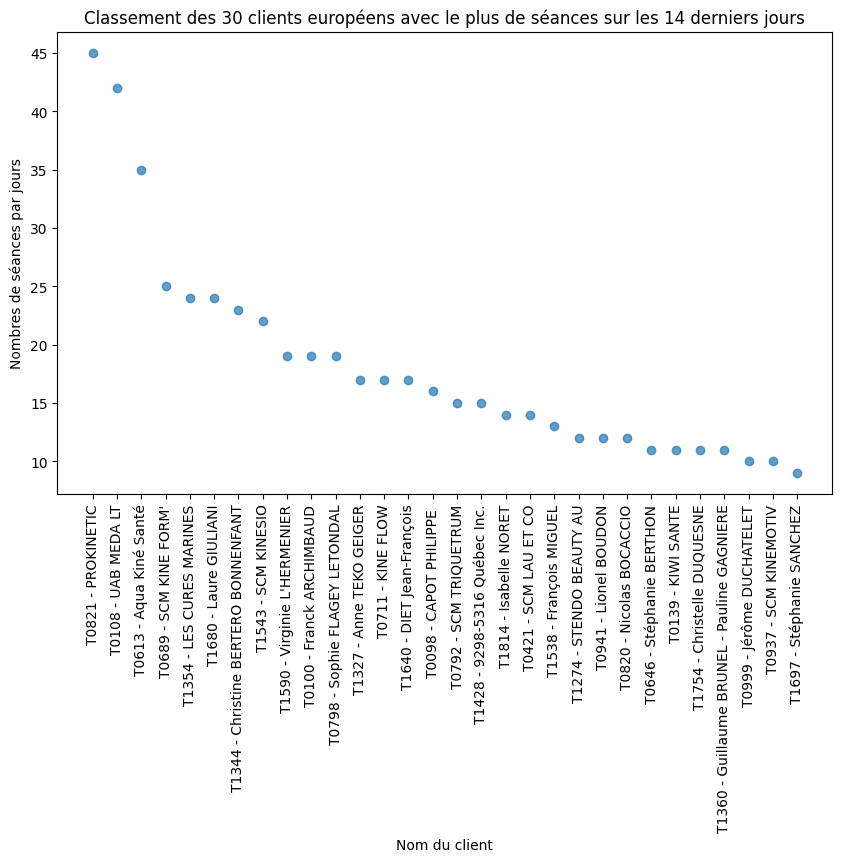

In [108]:
# @title
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(display_30_best_clients_activity_14_days.head(30)['Nom du client'], display_30_best_clients_activity_14_days.head(30)['Nombre de séances sur les 14 derniers jours'], alpha=0.7)
plt.xlabel('Nom du client')
plt.ylabel('Nombres de séances par jours')
plt.title('Classement des 30 clients européens avec le plus de séances sur les 14 derniers jours')
_ = plt.xticks(rotation=90)

# sur 30 jours

In [109]:
# @title
display_30_best_clients_activity_30_days = sorted_activity_europe_50[sorted_activity_europe_50['number_days'] > 30][['full_name.1', 'activity_last_30_days', 'rank_activity_30_days']].sort_values(by=['activity_last_30_days'], ascending=False)
display_30_best_clients_activity_30_days = display_30_best_clients_activity_30_days.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_last_30_days': 'Nombre de séances sur les 30 derniers jours',
    'rank_activity_30_days' : 'Classement en fonction de l\'activité sur les 30 derniers jours'
    })


display(display_30_best_clients_activity_30_days.head(30).style.hide(axis='index'))

Nom du client,Nombre de séances sur les 30 derniers jours,Classement en fonction de l'activité sur les 30 derniers jours
T0108 - UAB MEDA LT,186,1
T0821 - PROKINETIC,170,2
T1680 - Laure GIULIANI,160,3
T0613 - Aqua Kiné Santé,155,4
T0100 - Franck ARCHIMBAUD,107,5
T0711 - KINE FLOW,91,6
T1344 - Christine BERTERO BONNENFANT,86,7
T1640 - DIET Jean-François,82,8
T0689 - SCM KINE FORM',82,8
T0792 - SCM TRIQUETRUM,81,10


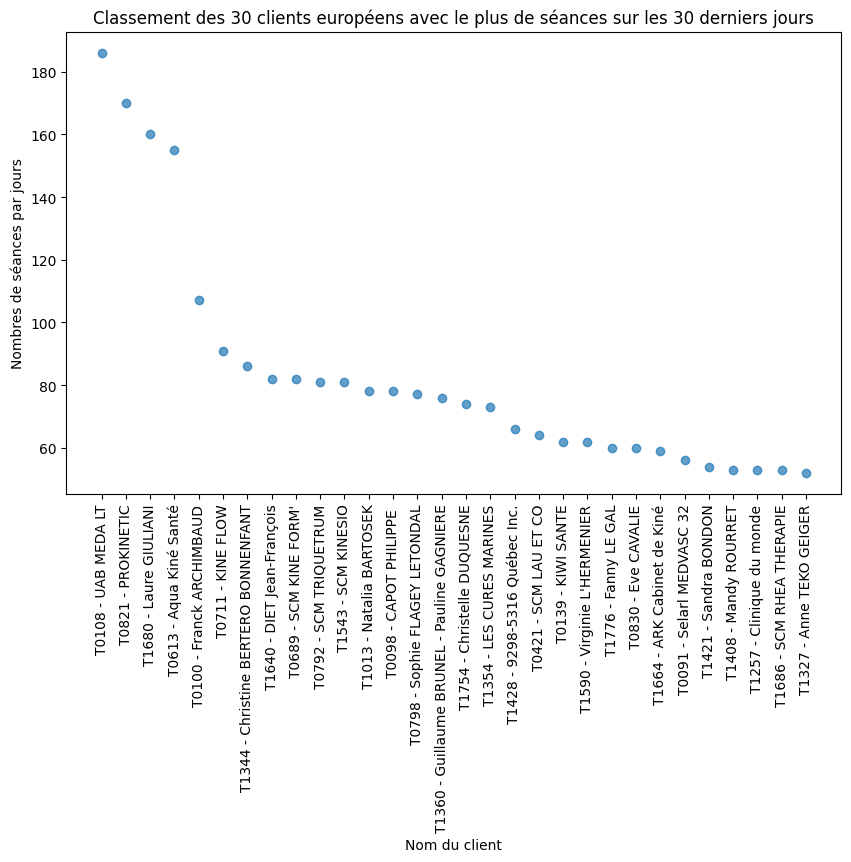

In [110]:
# @title
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(display_30_best_clients_activity_30_days.head(30)['Nom du client'], display_30_best_clients_activity_30_days.head(30)['Nombre de séances sur les 30 derniers jours'], alpha=0.7)
plt.xlabel('Nom du client')
plt.ylabel('Nombres de séances par jours')
plt.title('Classement des 30 clients européens avec le plus de séances sur les 30 derniers jours')
_ = plt.xticks(rotation=90)

# sur 90 jours

In [111]:
# @title
display_30_best_clients_activity_90_days = sorted_activity_europe_50[sorted_activity_europe_50['number_days'] > 90][['full_name.1', 'activity_last_90_days', 'rank_activity_90_days']].sort_values(by=['activity_last_90_days'], ascending=False)
display_30_best_clients_activity_90_days = display_30_best_clients_activity_90_days.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_last_90_days': 'Nombre de séances sur les 90 derniers jours',
    'rank_activity_90_days' : 'Classement en fonction de l\'activité sur les 90 derniers jours'
    })


display(display_30_best_clients_activity_90_days.head(30).style.hide(axis='index'))

Nom du client,Nombre de séances sur les 90 derniers jours,Classement en fonction de l'activité sur les 90 derniers jours
T0613 - Aqua Kiné Santé,952,1
T0108 - UAB MEDA LT,892,2
T0821 - PROKINETIC,710,3
T1680 - Laure GIULIANI,629,4
T0792 - SCM TRIQUETRUM,555,5
T0711 - KINE FLOW,545,6
T0100 - Franck ARCHIMBAUD,542,7
T0689 - SCM KINE FORM',488,8
T1344 - Christine BERTERO BONNENFANT,485,9
T0745 - Thibaut LEONE,457,10


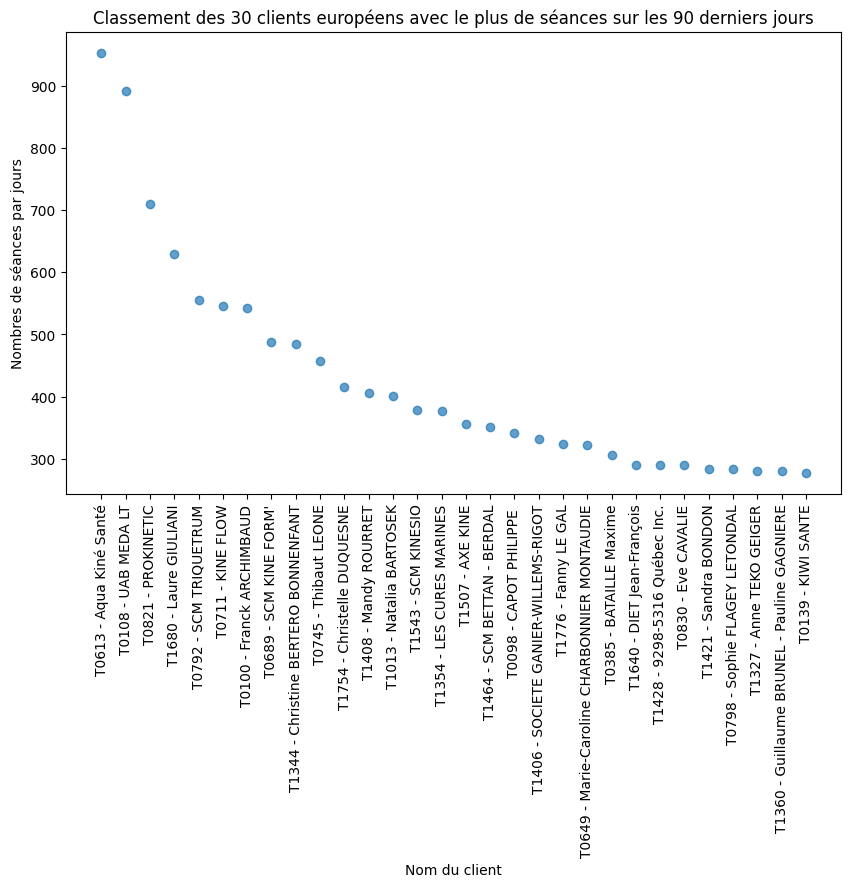

In [112]:
# @title
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(display_30_best_clients_activity_90_days.head(30)['Nom du client'], display_30_best_clients_activity_90_days.head(30)['Nombre de séances sur les 90 derniers jours'], alpha=0.7)
plt.xlabel('Nom du client')
plt.ylabel('Nombres de séances par jours')
plt.title('Classement des 30 clients européens avec le plus de séances sur les 90 derniers jours')
_ = plt.xticks(rotation=90)

# sur 1 an

In [113]:
# @title
display_30_best_clients_activity_year = sorted_activity_europe_50[sorted_activity_europe_50['number_days'] > 365][['full_name.1', 'activity_last_365_days', 'rank_activity_year']].sort_values(by=['activity_last_365_days'], ascending=False)
display_30_best_clients_activity_year = display_30_best_clients_activity_year.rename(columns={
    'full_name.1' : 'Nom du client',
    'activity_last_365_days': 'Nombre de séances sur 1 an',
    'rank_activity_year' : 'Classement en fonction de l\'activité sur 1 an'
    })


display(display_30_best_clients_activity_year.head(30).style.hide(axis='index'))

Nom du client,Nombre de séances sur 1 an,Classement en fonction de l'activité sur 1 an
T0613 - Aqua Kiné Santé,5541,1
T0100 - Franck ARCHIMBAUD,4002,2
T0108 - UAB MEDA LT,3429,3
T0711 - KINE FLOW,2676,4
T0821 - PROKINETIC,2482,5
T0745 - Thibaut LEONE,2279,6
T0091 - Selarl MEDVASC 32,2187,7
T0689 - SCM KINE FORM',2093,8
T1013 - Natalia BARTOSEK,1805,9
T1543 - SCM KINESIO,1773,10


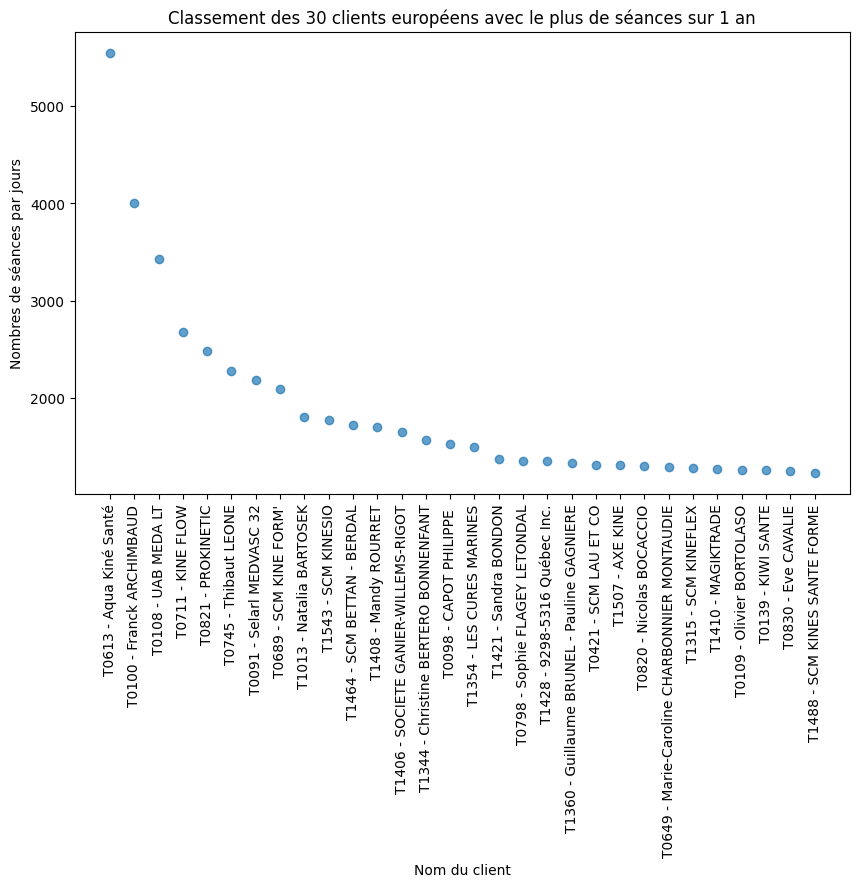

In [114]:
# @title
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(display_30_best_clients_activity_year.head(30)['Nom du client'], display_30_best_clients_activity_year.head(30)['Nombre de séances sur 1 an'], alpha=0.7)
plt.xlabel('Nom du client')
plt.ylabel('Nombres de séances par jours')
plt.title('Classement des 30 clients européens avec le plus de séances sur 1 an')
_ = plt.xticks(rotation=90)

# Tests sortie détails d'un client

In [115]:
# @title
# prompt: From the database sorted_activity_europe_50 display the following information:
# 1. The current date
# 2. The rank_activity_per_day of the full_name.1 called T0613 - Aqua Kiné Santé
# 3. The counts of the full_name.1 called T0613 - Aqua Kiné Santé
# 4. The activity_per_day of the full_name.1 called T0613 - Aqua Kiné Santé
# 5. The first_activity of the full_name.1 called T0613 - Aqua Kiné Santé
# 6. The last_activity of the full_name.1 called T0613 - Aqua Kiné Santé
# 7. The number_days of the full_name.1 called T0613 - Aqua Kiné Santé
# 8. The activity_last_7_days of the full_name.1 called T0613 - Aqua Kiné Santé
# 9. The activity_last_14_days of the full_name.1 called T0613 - Aqua Kiné Santé
# 10. The activity_last_30_days of the full_name.1 called T0613 - Aqua Kiné Santé

import datetime

# Assuming 'sorted_activity_europe_50' DataFrame is already available from the previous code

# Filter the DataFrame for the specific full_name.1
target_activity = sorted_activity_europe_50[sorted_activity_europe_50['full_name.1'] == 'T0613 - Aqua Kiné Santé']

if not target_activity.empty:
  current_date = datetime.date.today()
  rank = target_activity['rank_activity_per_day_since_acquisition'].iloc[0]
  counts = target_activity['counts'].iloc[0]
  activity_per_day = target_activity['activity_per_day_since_acquisition'].iloc[0]
  first_activity = target_activity['first_activity'].iloc[0]
  last_activity = target_activity['last_activity'].iloc[0]
  since_asquisition = target_activity['formatted_duration'].iloc[0]
  days_since_acquisition = target_activity['number_days'].iloc[0]
  activity_last_7_days = target_activity['activity_last_7_days'].iloc[0]
  activity_per_day_last_week = target_activity['activity_per_day_7_days'].iloc[0]
  rank_last_week = target_activity['rank_activity_7_days'].iloc[0]
  activity_last_14_days = target_activity['activity_last_14_days'].iloc[0]
  activity_per_day_last_2_week = target_activity['activity_per_day_14_days'].iloc[0]
  rank_last_2_week = target_activity['rank_activity_14_days'].iloc[0]
  activity_last_30_days = target_activity['activity_last_30_days'].iloc[0]
  activity_per_day_last_30_days = target_activity['activity_per_day_30_days'].iloc[0]
  rank_last_30_days = target_activity['rank_activity_30_days'].iloc[0]
  activity_last_90_days = target_activity['activity_last_90_days'].iloc[0]
  activity_per_day_last_90_days = target_activity['activity_per_day_90_days'].iloc[0]
  rank_last_90_days = target_activity['rank_activity_90_days'].iloc[0]
  activity_last_365_days = target_activity['activity_last_365_days'].iloc[0]
  activity_per_day_last_year = target_activity['activity_per_day_year'].iloc[0]
  rank_last_year = target_activity['rank_activity_year'].iloc[0]

  print('\033[1;4m' + "Détails pour le client T0613 - Aqua Kiné Santé:" + '\033[0m')
  print("\n")
  print(f"Date d\'aujourd\'hui: {current_date}")
  print(f"Date de la première séance: {first_activity}")
  print(f"Date de la dernière séance: {last_activity}")
  print(f"Première utilisation il y a: {since_asquisition} (ou {days_since_acquisition} jours)")
  print("\n")

  print('\033[1;4m' + "Stats sur les 7 derniers jours" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 7:
    print("Première séance effectué il ya moins de 7 jours.")
  print(f"Nombres de séances: {activity_last_7_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_week}")
  print(f"Classement: {rank_last_week} ")

  print("\n")
  print('\033[1;4m' + "Stats sur les 14 derniers jours" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 14:
    print("Première séance effectué il ya moins de 14 jours.")
  print(f"Nombres de séances: {activity_last_14_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_2_week}")
  print(f"Classement: {rank_last_2_week}")

  print("\n")
  print('\033[1;4m' + "Stats sur les 30 derniers jours" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 30:
    print("Première séance effectué il ya moins de 30 jours.")
  print(f"Nombres de séances: {activity_last_30_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_30_days}")
  print(f"Classement: {rank_last_30_days}")
  print("\n")

  print('\033[1;4m' + "Stats sur les 90 derniers jours" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 90:
    print("Première séance effectué il ya moins de 90 jours.")
  print(f"Nombres de séances: {activity_last_90_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_90_days}")
  print(f"Classement: {rank_last_90_days}")

  print("\n")
  print('\033[1;4m' + "Stats sur 1 an" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 365:
    print("Première séance effectué il ya moins de 365 jours.")
  print(f"Nombres de séances: {activity_last_365_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_year}")
  print(f"Classement: {rank_last_year}")
  print("\n")

  print('\033[1;4m' + "Stats depuis la première utilisation" + '\033[0m')
  print(f"Nombres de séances: {counts}")
  print(f"Nombres moyen de séances par jour: {activity_per_day}")
  print(f"Classement: {rank}")
else:
  print("T0613 - Aqua Kiné Santé not found in the database.")

Détails pour le client T0613 - Aqua Kiné Santé:


Date d'aujourd'hui: 2025-01-15
Date de la première séance: 2021-05-31 08:37:59
Date de la dernière séance: 2025-01-06 14:29:11
Première utilisation il y a: 3 an(s), 7 mois, 14 jour(s) (ou 1325 jours)


Stats sur les 7 derniers jours
Nombres de séances: 0
Nombres de séances par jour: 0.0
Classement: 1 


Stats sur les 14 derniers jours
Nombres de séances: 35
Nombres de séances par jour: 3.5
Classement: 3


Stats sur les 30 derniers jours
Nombres de séances: 155
Nombres de séances par jour: 7.75
Classement: 4


Stats sur les 90 derniers jours
Nombres de séances: 952
Nombres de séances par jour: 17.31
Classement: 1


Stats sur 1 an
Nombres de séances: 5541
Nombres de séances par jour: 25.19
Classement: 1


Stats depuis l'acquisition
Nombres de séances: 21593
Nombres moyen de séances par jour: 16.3
Classement: 1


In [116]:
# @title
# prompt: From the database sorted_activity_europe_50 display the following information:
# 1. The current date
# 2. The rank_activity_per_day of the full_name.1 called T0613 - Aqua Kiné Santé
# 3. The counts of the full_name.1 called T0613 - Aqua Kiné Santé
# 4. The activity_per_day of the full_name.1 called T0613 - Aqua Kiné Santé
# 5. The first_activity of the full_name.1 called T0613 - Aqua Kiné Santé
# 6. The last_activity of the full_name.1 called T0613 - Aqua Kiné Santé
# 7. The number_days of the full_name.1 called T0613 - Aqua Kiné Santé
# 8. The activity_last_7_days of the full_name.1 called T0613 - Aqua Kiné Santé
# 9. The activity_last_14_days of the full_name.1 called T0613 - Aqua Kiné Santé
# 10. The activity_last_30_days of the full_name.1 called T0613 - Aqua Kiné Santé

import datetime

# Assuming 'sorted_activity_europe_50' DataFrame is already available from the previous code

# Filter the DataFrame for the specific full_name.1
target_activity = sorted_activity_europe_50[sorted_activity_europe_50['full_name.1'] == 'T0100 - Franck ARCHIMBAUD']

if not target_activity.empty:
  current_date = datetime.date.today()
  rank = target_activity['rank_activity_per_day_since_acquisition'].iloc[0]
  counts = target_activity['counts'].iloc[0]
  activity_per_day = target_activity['activity_per_day_since_acquisition'].iloc[0]
  first_activity = target_activity['first_activity'].iloc[0]
  last_activity = target_activity['last_activity'].iloc[0]
  since_asquisition = target_activity['formatted_duration'].iloc[0]
  days_since_acquisition = target_activity['number_days'].iloc[0]
  activity_last_7_days = target_activity['activity_last_7_days'].iloc[0]
  activity_per_day_last_week = target_activity['activity_per_day_7_days'].iloc[0]
  rank_last_week = target_activity['rank_activity_7_days'].iloc[0]
  activity_last_14_days = target_activity['activity_last_14_days'].iloc[0]
  activity_per_day_last_2_week = target_activity['activity_per_day_14_days'].iloc[0]
  rank_last_2_week = target_activity['rank_activity_14_days'].iloc[0]
  activity_last_30_days = target_activity['activity_last_30_days'].iloc[0]
  activity_per_day_last_30_days = target_activity['activity_per_day_30_days'].iloc[0]
  rank_last_30_days = target_activity['rank_activity_30_days'].iloc[0]
  activity_last_90_days = target_activity['activity_last_90_days'].iloc[0]
  activity_per_day_last_90_days = target_activity['activity_per_day_90_days'].iloc[0]
  rank_last_90_days = target_activity['rank_activity_90_days'].iloc[0]
  activity_last_365_days = target_activity['activity_last_365_days'].iloc[0]
  activity_per_day_last_year = target_activity['activity_per_day_year'].iloc[0]
  rank_last_year = target_activity['rank_activity_year'].iloc[0]

  print('\033[1;4m' + "Détails pour le client T0100 - Franck ARCHIMBAUD:" + '\033[0m')
  print("\n")
  print(f"Date d\'aujourd\'hui: {current_date}")
  print(f"Date de la première séance: {first_activity}")
  print(f"Date de la dernière séance: {last_activity}")
  print(f"Première utilisation il y a: {since_asquisition} (ou {days_since_acquisition} jours)")
  print("\n")

  print('\033[1;4m' + "Stats sur les 7 derniers jours" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 7:
    print("Première séance effectué il ya moins de 7 jours.")
  print(f"Nombres de séances: {activity_last_7_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_week}")
  print(f"Classement: {rank_last_week} ")

  print("\n")
  print('\033[1;4m' + "Stats sur les 14 derniers jours" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 14:
    print("Première séance effectué il ya moins de 14 jours.")
  print(f"Nombres de séances: {activity_last_14_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_2_week}")
  print(f"Classement: {rank_last_2_week}")

  print("\n")
  print('\033[1;4m' + "Stats sur les 30 derniers jours" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 30:
    print("Première séance effectué il ya moins de 30 jours.")
  print(f"Nombres de séances: {activity_last_30_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_30_days}")
  print(f"Classement: {rank_last_30_days}")
  print("\n")

  print('\033[1;4m' + "Stats sur les 90 derniers jours" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 90:
    print("Première séance effectué il ya moins de 90 jours.")
  print(f"Nombres de séances: {activity_last_90_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_90_days}")
  print(f"Classement: {rank_last_90_days}")

  print("\n")
  print('\033[1;4m' + "Stats sur 1 an" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 365:
    print("Première séance effectué il ya moins de 365 jours.")
  print(f"Nombres de séances: {activity_last_365_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_year}")
  print(f"Classement: {rank_last_year}")
  print("\n")

  print('\033[1;4m' + "Stats depuis l\'acquisition" + '\033[0m')
  print(f"Nombres de séances: {counts}")
  print(f"Nombres moyen de séances par jour: {activity_per_day}")
  print(f"Classement: {rank}")
else:
  print("T0100 - Franck ARCHIMBAUD not found in the database.")

Détails pour le client T0100 - Franck ARCHIMBAUD:


Date d'aujourd'hui: 2025-01-15
Date de la première séance: 2020-02-10 16:07:32
Date de la dernière séance: 2025-01-06 14:53:22
Première utilisation il y a: 4 an(s), 11 mois, 4 jour(s) (ou 1801 jours)


Stats sur les 7 derniers jours
Nombres de séances: 0
Nombres de séances par jour: 0.0
Classement: 1 


Stats sur les 14 derniers jours
Nombres de séances: 19
Nombres de séances par jour: 1.9
Classement: 9


Stats sur les 30 derniers jours
Nombres de séances: 107
Nombres de séances par jour: 5.35
Classement: 5


Stats sur les 90 derniers jours
Nombres de séances: 542
Nombres de séances par jour: 9.85
Classement: 7


Stats sur 1 an
Nombres de séances: 4002
Nombres de séances par jour: 18.19
Classement: 2


Stats depuis l'acquisition
Nombres de séances: 21681
Nombres moyen de séances par jour: 12.04
Classement: 2


In [117]:
# @title
# prompt: From the database sorted_activity_europe_50 display the following information:
# 1. The current date
# 2. The rank_activity_per_day of the full_name.1 called T0613 - Aqua Kiné Santé
# 3. The counts of the full_name.1 called T0613 - Aqua Kiné Santé
# 4. The activity_per_day of the full_name.1 called T0613 - Aqua Kiné Santé
# 5. The first_activity of the full_name.1 called T0613 - Aqua Kiné Santé
# 6. The last_activity of the full_name.1 called T0613 - Aqua Kiné Santé
# 7. The number_days of the full_name.1 called T0613 - Aqua Kiné Santé
# 8. The activity_last_7_days of the full_name.1 called T0613 - Aqua Kiné Santé
# 9. The activity_last_14_days of the full_name.1 called T0613 - Aqua Kiné Santé
# 10. The activity_last_30_days of the full_name.1 called T0613 - Aqua Kiné Santé

import datetime

# Assuming 'sorted_activity_europe_50' DataFrame is already available from the previous code

# Filter the DataFrame for the specific full_name.1
target_activity = sorted_activity_europe_50[sorted_activity_europe_50['full_name.1'] == 'T1680 - Laure GIULIANI']

if not target_activity.empty:
  current_date = datetime.date.today()
  rank = target_activity['rank_activity_per_day_since_acquisition'].iloc[0]
  counts = target_activity['counts'].iloc[0]
  activity_per_day = target_activity['activity_per_day_since_acquisition'].iloc[0]
  first_activity = target_activity['first_activity'].iloc[0]
  last_activity = target_activity['last_activity'].iloc[0]
  since_asquisition = target_activity['formatted_duration'].iloc[0]
  days_since_acquisition = target_activity['number_days'].iloc[0]
  activity_last_7_days = target_activity['activity_last_7_days'].iloc[0]
  activity_per_day_last_week = target_activity['activity_per_day_7_days'].iloc[0]
  rank_last_week = target_activity['rank_activity_7_days'].iloc[0]
  activity_last_14_days = target_activity['activity_last_14_days'].iloc[0]
  activity_per_day_last_2_week = target_activity['activity_per_day_14_days'].iloc[0]
  rank_last_2_week = target_activity['rank_activity_14_days'].iloc[0]
  activity_last_30_days = target_activity['activity_last_30_days'].iloc[0]
  activity_per_day_last_30_days = target_activity['activity_per_day_30_days'].iloc[0]
  rank_last_30_days = target_activity['rank_activity_30_days'].iloc[0]
  activity_last_90_days = target_activity['activity_last_90_days'].iloc[0]
  activity_per_day_last_90_days = target_activity['activity_per_day_90_days'].iloc[0]
  rank_last_90_days = target_activity['rank_activity_90_days'].iloc[0]
  activity_last_365_days = target_activity['activity_last_365_days'].iloc[0]
  activity_per_day_last_year = target_activity['activity_per_day_year'].iloc[0]
  rank_last_year = target_activity['rank_activity_year'].iloc[0]

  print('\033[1;4m' + "Détails pour le client T1680 - Laure GIULIANI:" + '\033[0m')
  print("\n")
  print(f"Date d\'aujourd\'hui: {current_date}")
  print(f"Date de la première séance: {first_activity}")
  print(f"Date de la dernière séance: {last_activity}")
  print(f"Première utilisation il y a: {since_asquisition} (ou {days_since_acquisition} jours)")
  print("\n")

  print('\033[1;4m' + "Stats sur les 7 derniers jours" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 7:
    print("Première séance effectué il ya moins de 7 jours.")
  print(f"Nombres de séances: {activity_last_7_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_week}")
  print(f"Classement: {rank_last_week} ")

  print("\n")
  print('\033[1;4m' + "Stats sur les 14 derniers jours" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 14:
    print("Première séance effectué il ya moins de 14 jours.")
  print(f"Nombres de séances: {activity_last_14_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_2_week}")
  print(f"Classement: {rank_last_2_week}")

  print("\n")
  print('\033[1;4m' + "Stats sur les 30 derniers jours" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 30:
    print("Première séance effectué il ya moins de 30 jours.")
  print(f"Nombres de séances: {activity_last_30_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_30_days}")
  print(f"Classement: {rank_last_30_days}")
  print("\n")

  print('\033[1;4m' + "Stats sur les 90 derniers jours" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 90:
    print("Première séance effectué il ya moins de 90 jours.")
  print(f"Nombres de séances: {activity_last_90_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_90_days}")
  print(f"Classement: {rank_last_90_days}")

  print("\n")
  print('\033[1;4m' + "Stats sur 1 an" + '\033[0m')
  if target_activity['number_days'].iloc[0] < 365:
    print("Première séance effectué il ya moins de 365 jours.")
  print(f"Nombres de séances: {activity_last_365_days}")
  print(f"Nombres de séances par jour: {activity_per_day_last_year}")
  print(f"Classement: {rank_last_year}")
  print("\n")

  print('\033[1;4m' + "Stats depuis l\'acquisition" + '\033[0m')
  print(f"Nombres de séances: {counts}")
  print(f"Nombres moyen de séances par jour: {activity_per_day}")
  print(f"Classement: {rank}")
else:
  print("T1680 - Laure GIULIANI not found in the database.")

Détails pour le client T1680 - Laure GIULIANI:


Date d'aujourd'hui: 2025-01-15
Date de la première séance: 2024-07-18 11:00:30
Date de la dernière séance: 2025-01-06 14:26:00
Première utilisation il y a: 0 an(s), 5 mois, 27 jour(s) (ou 181 jours)


Stats sur les 7 derniers jours
Nombres de séances: 0
Nombres de séances par jour: 0.0
Classement: 1 


Stats sur les 14 derniers jours
Nombres de séances: 24
Nombres de séances par jour: 2.4
Classement: 5


Stats sur les 30 derniers jours
Nombres de séances: 160
Nombres de séances par jour: 8.0
Classement: 3


Stats sur les 90 derniers jours
Nombres de séances: 629
Nombres de séances par jour: 11.44
Classement: 4


Stats sur 1 an
Première séance effectué il ya moins de 365 jours.
Nombres de séances: 1337
Nombres de séances par jour: 6.08
Classement: 22


Stats depuis l'acquisition
Nombres de séances: 1337
Nombres moyen de séances par jour: 7.39
Classement: 5
